# MCB 112 PSet 10


In [1]:
import numpy as np
import re
import scipy.stats       as stats
import scipy.optimize    as optimize
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
%load_ext watermark
%watermark -v -m -p jupyter,numpy,matplotlib,scipy,re

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

jupyter   : unknown
numpy     : 1.26.4
matplotlib: 3.9.2
scipy     : 1.13.1
re        : 2.2.1

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit



## 1. solve by maximum likelihood

Below, I define a function `nll` that computes the negative log likelihood of the observed 24-hr RNA-seq data given an estimate of the parameters of the model. As a reminder, our sinusoidal model is specified as $y(t) = b + a\sin(2\pi\omega(t + \phi)) + \epsilon_i$, where $\epsilon_i$ is a Normally distributed error term with known variance. As parameters, the function `nll` takes `p`, an array of the parameters in the model: $[b,a, \phi]$, and $D$ an array of vectors of the time, expression levels, and known standard errors: $[\vec{t}, \vec{y}, \vec{\sigma}]$. 

After parsing in those parameters, the function loops through each of the 8 measurement timepoints and calculates the residual associated with that measurement $\hat{\epsilon}(t) = y(t) - \hat{y}(t)$, where $\hat{y}(t) = b + a\sin(2\pi\omega(t + \phi))$. Under our error model for these data, we have that the residuals are normally distributed with known standard error $\sigma(t)$. As such, the log likelihood for an observation given the parameter vector $\vec{\theta}$ is: $\log P(y(t) \mid \vec{\theta}) = \log P(\hat{\epsilon} \mid \vec{\theta}) = \log \left( \phi(\frac{\hat{\epsilon}}{\sigma}) \right)$, where $\phi$ is the $N(0,1)$ pdf. The total log likelihood of the data vector $\vec{y}$ is the sum across the log likelihood for each data point: $\log (P(\vec{y} \mid \vec{\theta}) = \sum_{t} \log P(y(t) \mid \vec{\theta})$.

In the function below, I implement this calculation using the `stats.norm.logpdf` function with location and scale parameters. Since our ML method will work via objective function minimization, `nll` returns the negative log likelihood of the observed dataset.

In [3]:
def nll (p, D):
    #setting and reading in parameters
    w = 1/24
    b = p[0]
    a = p[1]
    phi = p[2]
    log_likelihood = 0 #initializes log likelihood calculation

    for i in range(len(D[0])): #loops through data points
        t = D[0][i] #gets time
        y = D[1][i] #gets TPM counts
        sigma = D[2][i] #gets variance for that timepoint
        epsilon = y - (b + a*np.sin(2*np.pi*w*(t+phi))) #calculates residual
        log_likelihood += stats.norm.logpdf(epsilon, loc = 0, scale = sigma) #appends current log likelihood to total

    return -log_likelihood

Below, I have pasted and edited the `read_table` function from Moriarty's script that was provided on the PSet. The function takes in a `filename` as a parameter. It reads the file line by line and then returns `X` (the timepoints), `S_true` (the true, known standard deviation of measurements at each timepoint), `Y` (the tpm measurement timecourse for each of the 12 genes), and `genenames` (a list of the 12 gene names). 

In [4]:
def read_table (filename):
    with open(filename) as f:
        # Reads in timepoints
        fields = f.readline().split()
        X = []
        for s in fields:
            match = re.search(r'^(\d+)hr', s)
            X.append(int(match.group(1)))
        X = np.array(X)
        N = len(X)
    
        # Reads in standard deviations
        fields = f.readline().split()
        S_true = np.zeros(N)
        for i,s in enumerate(fields[1:]):
            match = re.search(r'^\+-(\d+)', s)
            S_true[i] = float(match.group(1))
    
        f.readline()
    
        # Reads in TPM timecourse for each gene
        genenames = []
        Y = []
        for line in f.readlines():
            fields = line.split()
            genenames.append(fields[0])
            Y.append( np.array( [ float(s) for s in fields[1:]] ))
        G = len(Y)

    return X,S_true,Y,genenames

In [5]:
X,S,Y,genes = read_table("w10-data.tbl")

Below, I run the maximum likelihood optimization on each of the 12 gene TPM timecourses. For each iteration, I collect the appropriate inputs in the `data` array. Then, I run the `scipy.optimize.minimize` function on the `nll` objective function, `p0` initial parameter estimates, and the `data` array to identify the parameter estimates that minimize the negative log likelihood value. I append these parameter estimates to the `ml_params` array and also store the negative log likelihood values in the `nlls` array.  

In [6]:
ml_params = [] #will store parameter estimates
nlls = [] #will store negative log likelihood for each gene
p0 = np.array([40,20,0]) #initial parameter estimates

for i in range(len(Y)): #loops through each gene
    data = np.array([X,Y[i],S]) #gets associated data
    results = optimize.minimize(nll, p0, data) #runs optimization
    ml_params.append(results.x) #collects parameter estimates
    nlls.append(results.fun) #collects negative log likelihood

ml_params = np.array(ml_params)
nlls = np.array(nlls)

Below, I output the parameter estimates from the maximum likelihood model using the script provided at the end of `moriarty.py`. Before outputting the parameters, however, I first make sure that the phases $\phi$ are in the range $[0,24]$. Circadian rythms are periodic over 24 hours. As a result, the fit is invariant under adding/subtracting 24 hours from the phase $\phi$. Note, however, that this phase is most interpretable within the context of a 24-hour circadian rhytgm when it is in the range $[0,24]$ (within 1 day). Therefore, before outputting the parameter estimates, I first use while loops to add/subtract 24 from the phase estimates until they are contained within this desired interval. 

In [7]:
for i in range(len(ml_params)):
    phi = ml_params[i][2]
    while phi < 0:
        phi = phi + 24
    while phi > 24:
        phi = phi - 24
    ml_params[i][2] = phi

print("{0:12s} {1:>6s} {2:>6s} {3:>6s}".format('genename', 'b', 'a', 'p'))
print("{0:12s} {1:6s} {2:6s} {3:6s}".format('-'*12, '-'*6,'-'*6,'-'*6))
for i in range(len(genes)):
    print("{0:12s} {1:6.2f} {2:6.2f} {3:6.2f}".format(genes[i], ml_params[i][0], ml_params[i][1], ml_params[i][2]))

genename          b      a      p
------------ ------ ------ ------
wkiN          47.59  19.05  19.80
wicQ          37.64  20.87  16.62
zgvC          45.00  25.11  12.14
dczC          49.38  27.25   3.88
jarO          43.68  22.93   0.13
lfpY          40.86  22.86   9.61
retS          49.04  25.25   8.21
cbaJ          47.50  21.94   1.92
vdbK          45.39  17.55   6.19
slwZ          45.42  26.45  22.39
wjmU          49.13  29.93  17.99
uhxN          46.35  23.16  14.10


## 2. compare solutions

Below, I run the python script `moriarty.py` that was provided on the PSet that replicates Moriarty's harmonic regression solution and outputs a table containing his best parameter estimates for each gene. I copy and pasted the output into a text file called `moriarty_results.tbl` that I will read next.

In [8]:
%%bash
python moriarty.py w10-data.tbl

genename          b      a      p
------------ ------ ------ ------
wkiN          45.58  17.02  19.53
wicQ          31.60   6.80  14.50
zgvC          45.91  29.74  12.45
dczC          49.64  30.40   5.07
jarO          43.96  35.18  22.44
lfpY          38.26  19.20   9.59
retS          48.19  17.17   7.83
cbaJ          36.32  26.35   0.09
vdbK          42.27  12.71   5.74
slwZ          40.55  26.10   0.32
wjmU          55.55  33.16  18.67
uhxN          46.26  15.10  15.60


Below, I define a function `read_moriarty`, adapted from the provided `read_table` function to read in the `moriarty_results.tbl` file. It reads the file line by line, and it skips over the first two lines as they contain header and formatting characters. Then for each data row (representing the parameter estimates for each gene), the function collects the gene name in the `genenames` array and then collects the three parameter estiamtes for $b, a, \phi$ in the `params` array. The function returns these two arrays once they have been populated for each of the 12 genes.

In [9]:
def read_moriarty (filename):
    with open(filename) as f: #reads file line by line
        #skips over first two lines, as they do not contain data
        f.readline()
        f.readline()
    
        #remaining lines are data
        genenames = [] #will store genenames
        params = [] #will store parameter estimates across the 12 genes
        for line in f.readlines(): #reads the current line
            fields = line.split() #splits the line based on white space
            genenames.append(fields[0]) #gets the genename
            #gets the three parameter estimates for the current gene
            params.append( np.array( [ float(s) for s in fields[1:]] ))

    return genenames, params

In [10]:
genes, moriarty_params = read_moriarty("moriarty_results.tbl") #reads in Moriarty's parameter estiamtes

Below, I compute the negative log likelihoods of Moriarty's estimated models for each gene timecourse in the given dataset. I use a `for` loop to loop through each gene in the dataset. For each gene, I collect the parameter estimate array `params` and the data array `data`. I then feed these arraays to the `nll` function, which computes the negative log likelihood. 

Then, I now have an array `nlls` that contains the negative log likelihoods for each of the 12 gene TPM timecourses based on the maximum likelihood model and `moriarty_nlls`, which contains the negative log likelihoods for the genes based on Moriarty's harmonic regression model.

In [11]:
moriarty_nlls = []

for i in range(len(Y)):
    params = moriarty_params[i]
    data = np.array([X,Y[i],S])
    moriarty_nlls.append(nll(params, data))

moriarty_nlls = np.array(moriarty_nlls)

The total negative log likelihood of the entire dataset is the sum of all elements within the array, which I implement with the `np.sum` function. Comparing the negative log likelihoods shows that the maximum likelihood approach has the lower value (311.835 vs. 519.2429). This supports the conclusion that the maximum likelihood model is a better fit for the observed data than Moriarty's harmonic regression model.

Interpreting these log likelihoods, we use properties of log to get the log likelihood ratio between the two models: $\log P(\vec{y} \mid \hat{\vec{\theta}}_1) - \log P(\vec{y} \mid \hat{\vec{\theta}}_2) = \log \frac{P(\vec{y} \mid \hat{\vec{\theta}}_1)}{P(\vec{y} \mid \hat{\vec{\theta}}_2)}$. Exponentiating the log likelihood ratio will give us the likelihood ratio in probability space. I implement this calculation below:

In [12]:
print(f"Total negative log-likelihood for ML: {np.round(np.sum(nlls), decimals = 4)}")
print(f"Total negative log-likelihood for HR: {np.round(np.sum(moriarty_nlls), decimals = 4)}")

ll_ml = - np.sum(nlls)
ll_lr = -np.sum(moriarty_nlls)
log_likelihood_ratio = ll_ml - ll_lr
probability_ratio = np.exp(log_likelihood_ratio)
print(f"Likelihood Ratio = {"{:.2e}".format(probability_ratio)}")

Total negative log-likelihood for ML: 311.835
Total negative log-likelihood for HR: 519.2429
Likelihood Ratio = 1.19e+90


We have a very large likelihood ratio that suggests that the maximum-likelihood model is $1.9 \cdot 10^{90}$ more likely a fit for the TPM dataset than Moriarty's harmonic regression model. This means that the probability that the maximum-likelihood ratio is a better fit to the dataset is very nearly 1. This means that our odds of winning the bet approach $\frac{p}{1-p} \rightarrow \infty$ as $p \rightarrow 1$. Therefore, if Moriarty is willing to offer us even odds (in which he estimates the the odds of the maximum likelihood winning are $\frac{0.5}{1-0.5} = 1$), we should take the bet as the pub is severely underestimating the probability that the maximum likelihood model will win out.  

## 3. plot the fits

Below, I use the `matplotlib.pyplot.subplots`, `matplotlib.pyplot.scatter`, and `matplotlib.pyplot.scatter` functions to create a multipanel figure that displays the RNA-seq counts in TPM across the 24 hours as scatter points and plots the maximum likelihood and harmonic regression curves on the same plot. I do this for all 12 genes in the dataset.

Thankfully, all the code in this notebook has preserved the ordering of the genes, parameters, and timepoints across their respective arrays for the two models, so I could use common indices to get the information for each model. For the scatterplot, I have color coded the points according to their known standard deviations: {red: $\sigma = 20$, blue: $\sigma = 2$, green: $\sigma = 5$}. 

Comparing the two model fits below, we see that Moriarty's harmonic regression model weights all data points equally, regardless of the error associated with that point. This is because standard linear regression assumes that all errors in the dataset are distributed with constant variance $\sigma^2$. As a result, the harmonic regression curve is equally influenced by the high error ones as it is the low error ones. Since they are extra noisy, the high error points have the effect of drawing the harmonic regression line towards them, often away from the actual trend in the data, which makes for a poorer fit. 

By contrast, the maximum likelihood model accounts for the variable error across datapoints by through computing the log likelihood using Normal distributions with the known standard error parameters. For noisy measurements, this approach recognizes that they will vary more from their true values and the corresponding likelihood calculation doesn't penalize these noisy points as much as in the harmonic regression model. Indeed, the harmonic regression model loses its accuracy of fit in trying to fit these high error points. The maximum likelihood approach, however, effectively downweights these points by recognizing they will inherently be much noisier and instead chooses to fit more closely to the low error points. 

This distinction is very apparent graphically. Consider the plot for gene wicQ (1st row, 2nd column). The Harmonic regression curve in orange has a much smaller amplitude as it tries to fit the closely clustered points in red, which have $\sigma = 20$. The ML Model accounts for the fact that these points have high error and instead chooses to minimize likelihood by fitting more closely to the low error (green and blue) points. 

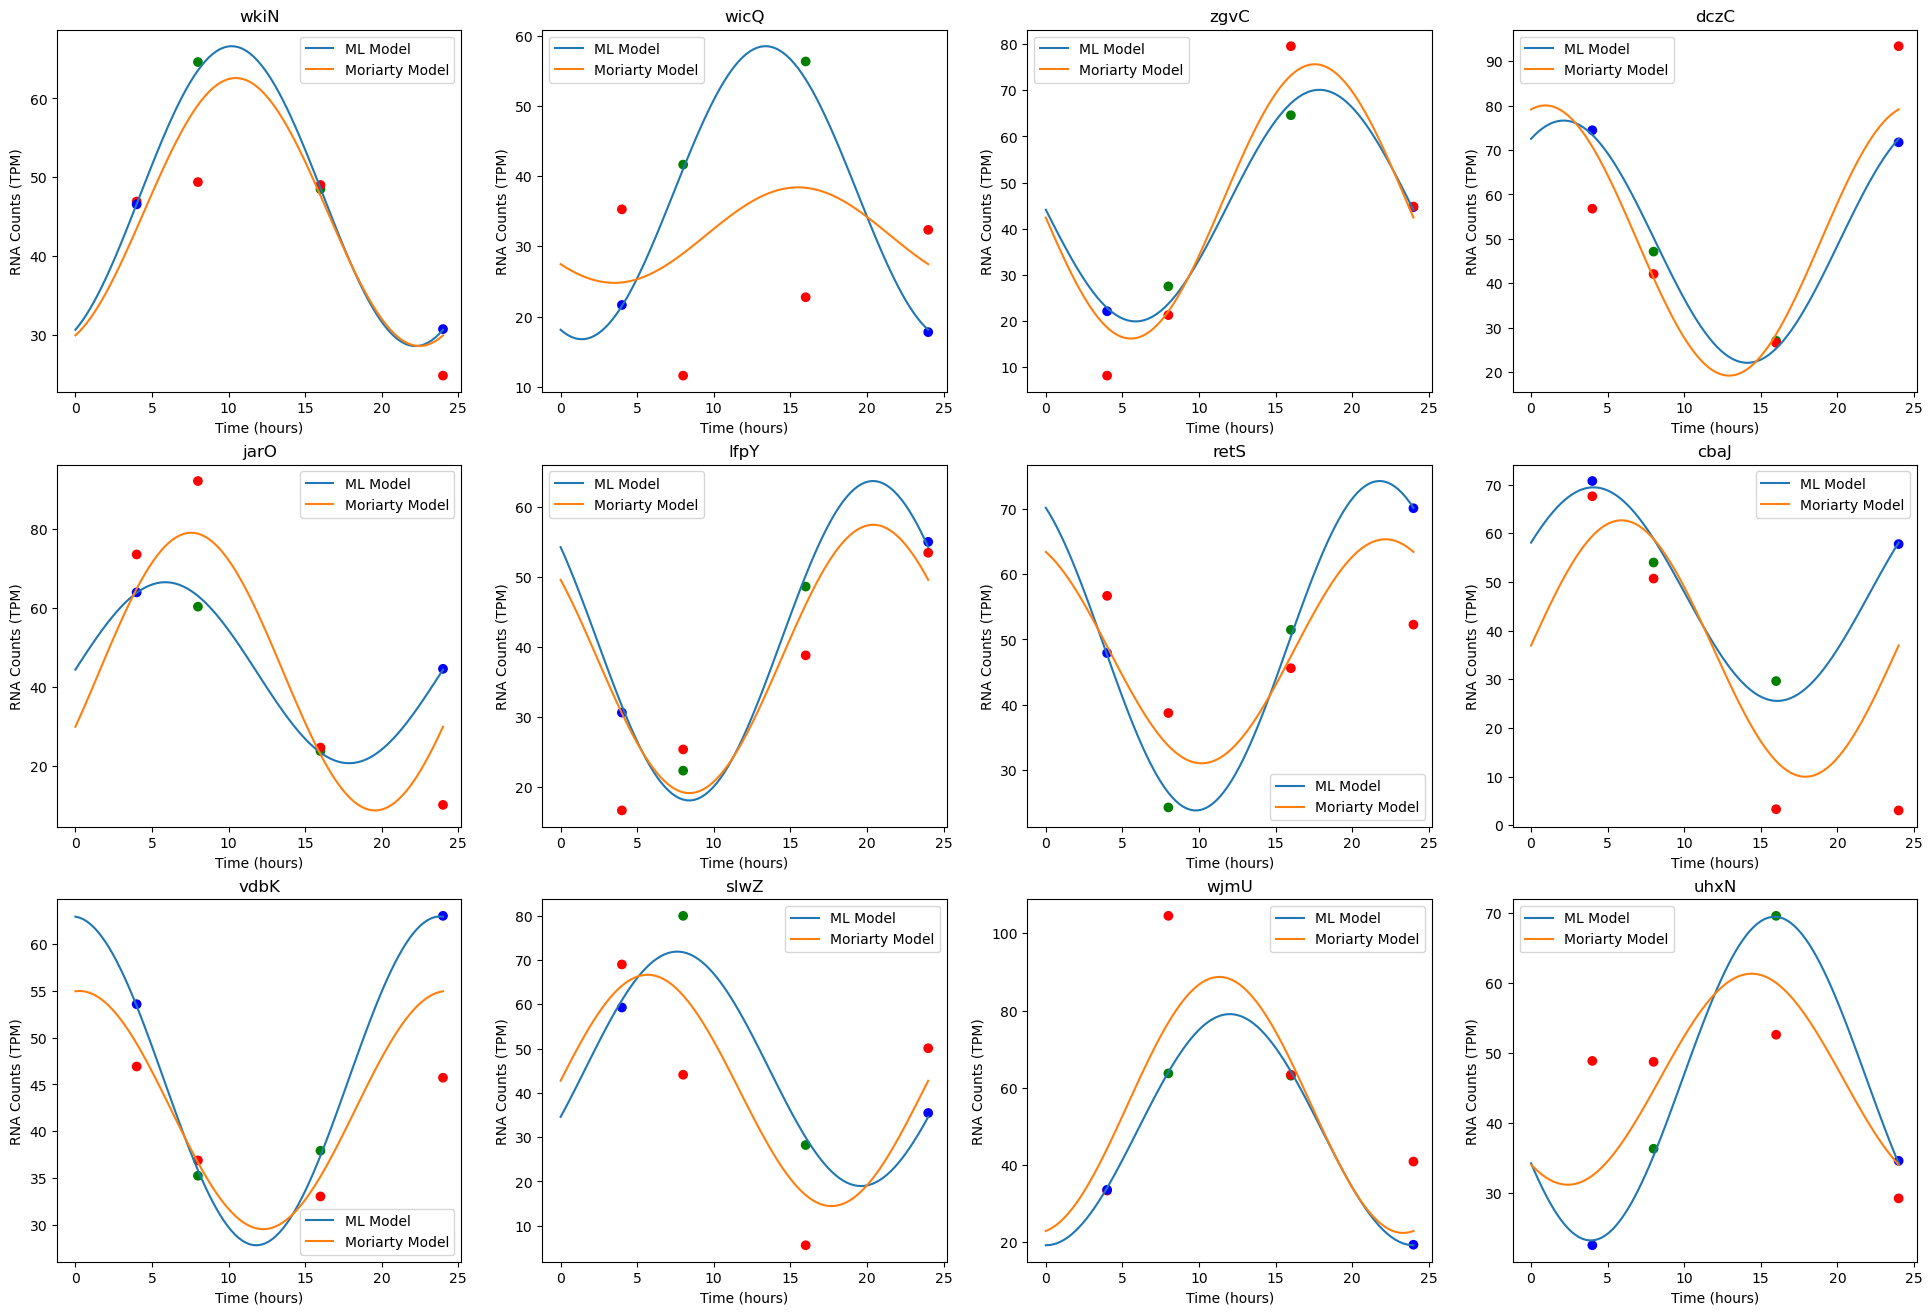

In [13]:
c = ['r', 'b', 'r', 'g', 'g', 'r', 'b', 'r']
fig, axes = plt.subplots(3,4, figsize = (24,16))

for i in range(len(Y)):
    row = int(i/4)
    column = i%4

    axes[row][column].scatter(X,Y[i],color = c)


    b = ml_params[i][0]
    a = ml_params[i][1]
    phi = ml_params[i][2]
    x_ml = np.linspace(0,24,100)
    y_ml = b + a*np.sin(2*np.pi*(1/24)*(x_ml + phi))
    axes[row][column].plot(x_ml, y_ml, label = "ML Model")

    b = moriarty_params[i][0]
    a = moriarty_params[i][1]
    phi = moriarty_params[i][2]
    x_moriarty = np.linspace(0,24,100)
    y_moriarty = b + a*np.sin(2*np.pi*(1/24)*(x_moriarty + phi))
    axes[row][column].plot(x_moriarty, y_moriarty, label = "Moriarty Model")

    axes[row][column].legend()
    axes[row][column].set_xlabel("Time (hours)")
    axes[row][column].set_ylabel("RNA Counts (TPM)")
    axes[row][column].set_title(genes[i])

plt.show()